# Project 7: Implement a scoring model.

*Pierre-Eloi Ragetly*

This project is part of the Data Scientist path proposed by OpenClassrooms.

In [1]:
# File system management
import os

# Get execution time to compare models
import time

# Import numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams.update({'axes.edgecolor': 'white',
                     'axes.facecolor': 'white',
                     'axes.linewidth': 2.0,
                     'figure.facecolor': 'white'})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    folder_path = os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    path = os.path.join("charts", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare the data</a></span><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read in data</a></span></li><li><span><a href="#Transform-data" data-toc-modified-id="Transform-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Transform data</a></span></li></ul></li><li><span><a href="#Shortlist-Promising-Models" data-toc-modified-id="Shortlist-Promising-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shortlist Promising Models</a></span><ul class="toc-item"><li><span><a href="#Select-a-Performance-Measure" data-toc-modified-id="Select-a-Performance-Measure-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Select a Performance Measure</a></span></li><li><span><a href="#Establish-a-performance-baseline" data-toc-modified-id="Establish-a-performance-baseline-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Establish a performance baseline</a></span></li><li><span><a href="#Train-quick-and-dirty-models-and-compare-their-performance" data-toc-modified-id="Train-quick-and-dirty-models-and-compare-their-performance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train quick and dirty models and compare their performance</a></span></li><li><span><a href="#Data-augmentation-with-SMOTE" data-toc-modified-id="Data-augmentation-with-SMOTE-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data augmentation with SMOTE</a></span></li><li><span><a href="#Problem-of-overfitting" data-toc-modified-id="Problem-of-overfitting-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Problem of overfitting</a></span></li></ul></li><li><span><a href="#Improve-Data-Preprocessing" data-toc-modified-id="Improve-Data-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Improve Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Improve-the-preparation-pipeline" data-toc-modified-id="Improve-the-preparation-pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Improve the preparation pipeline</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature Selection</a></span></li></ul></li><li><span><a href="#Fine-Tune-the-hyperparameters" data-toc-modified-id="Fine-Tune-the-hyperparameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fine-Tune the hyperparameters</a></span><ul class="toc-item"><li><span><a href="#Logitic-Regression" data-toc-modified-id="Logitic-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Logitic Regression</a></span></li><li><span><a href="#Linear-SVM" data-toc-modified-id="Linear-SVM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear SVM</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Stacking-Classifier" data-toc-modified-id="Stacking-Classifier-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Stacking Classifier</a></span></li><li><span><a href="#Compare-Results" data-toc-modified-id="Compare-Results-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Compare Results</a></span></li><li><span><a href="#Set-a-threshold-for-predicition" data-toc-modified-id="Set-a-threshold-for-predicition-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Set a threshold for predicition</a></span></li><li><span><a href="#Final-prediction" data-toc-modified-id="Final-prediction-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Final prediction</a></span></li></ul></li><li><span><a href="#Analyse-feature-importance-with-SHAP" data-toc-modified-id="Analyse-feature-importance-with-SHAP-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analyse feature importance with SHAP</a></span></li><li><span><a href="#Appendix,-XGBoost-fine-tuning" data-toc-modified-id="Appendix,-XGBoost-fine-tuning-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Appendix, XGBoost fine-tuning</a></span></li></ul></div>

## Prepare the data

### Read in data

In [2]:
list_files = sorted(os.listdir("data/"), key=str.lower)
for i, file in enumerate(list_files):
    print("{}) {}".format(i+1, file))

#app_test = pd.read_csv("data/" + list_files[0])
app_train = pd.read_csv("data/" + list_files[1])
#bureau =  pd.read_csv("data/" + list_files[2])
#b_b = pd.read_csv("data/" + list_files[3])
#cc_balance = pd.read_csv("data/" + list_files[4])
#ins_payments = pd.read_csv("data/" + list_files[6])
#pos_cash = pd.read_csv("data/" + list_files[7])
#prev_app = pd.read_csv("data/" + list_files[8])

1) application_test.csv
2) application_train.csv
3) bureau.csv
4) bureau_balance.csv
5) credit_card_balance.csv
6) HomeCredit_columns_description.csv
7) installments_payments.csv
8) POS_CASH_balance.csv
9) previous_application.csv
10) sample_submission.csv


### Transform data

We will drop the *SK_ID_CURR* features for the modeling. Being an ID, it is unique for each client, and so does not bring any information.

- *SK_ID_CURR*
- *EXT_SOURCE_1*
- *EXT_SOURCE_2*
- *EXT_SOURCE_3*

The first one is an id, meaning it is unique for each client, and so does not bring any information.
For the three "EXT_SOURCE", it is totally different. The correlation study made previously suggests these features could be the major contributors of the final model. However, not knowing how these scores have been calculated, it would be impossible to us to explain a model based on them.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from functions.preprocessing import NaAttFilter
from functions.preprocessing import SparseCleaner, DenseCleaner
from functions.preprocessing import DomainAdder
from functions.preprocessing import SkewCleaner

# Drop the target and the ID of input data
# as well as sourc 
X = app_train.drop(['SK_ID_CURR',
                    #'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                    'TARGET'], axis=1)

# Get the categorical attributes
cat_att = X.select_dtypes('object').columns
# Get the numerical attributes
num_att = X.select_dtypes(['number']).columns
ord_att = X[num_att].loc[:, X[num_att].nunique()<6].columns
sparse_att = np.array([c for c in num_att
                       if c not in ord_att
                       and (X[c]==0).sum() > 0.5*len(X)])
dense_att = np.array([c for c in num_att
                      if c not in ord_att
                      and c not in sparse_att])

# Create a pipeline for all data preparation
cat_pipeline = Pipeline([
               ('filter', NaAttFilter()),               
               ('imputer', SimpleImputer(strategy='most_frequent')),
               ('encoder', OneHotEncoder(drop='if_binary')),
               ])
ord_pipeline = Pipeline([
               ('filter', NaAttFilter()),
               ('imputer', SimpleImputer(strategy='most_frequent'))
               ])

sparse_pipeline = Pipeline([
                  ('filter', NaAttFilter()),
                  ('cleaner', SparseCleaner()),
                  ('imputer', SimpleImputer(strategy='most_frequent')),
                  ('scaler', MaxAbsScaler())
                  ])

dense_pipeline = Pipeline([
                 ('filter', NaAttFilter()),
                 ('cleaner', DenseCleaner()),
                 ('domain_adder', DomainAdder()),
                 ('skew_transformer', SkewCleaner()),
                 ('imputer', SimpleImputer()),
                 ('scaler', StandardScaler())
                 ])

prep_pipeline = ColumnTransformer([
                ('cat', cat_pipeline, cat_att),
                ('ord', ord_pipeline, ord_att),
                ('sparse', sparse_pipeline, sparse_att),
                ('dense', dense_pipeline, dense_att),
                ])

In [4]:
# Prepare data
y = app_train['TARGET']
X_pr = prep_pipeline.fit_transform(X)
print(X_pr.shape)
# Get the name of the transformed categorical features
cat_pipeline.fit(X[cat_att]) # required to get attributes, ColumnTransformer bug?
cat_mask = prep_pipeline.get_params()['cat__filter'].mask_
encoder = prep_pipeline.get_params()['cat__encoder']
cat_att_tr = encoder.get_feature_names_out(cat_att[~cat_mask])
# Get the name of the transformed ordinal features
ord_pipeline.fit(X[ord_att])
ord_mask = prep_pipeline.get_params()['ord__filter'].mask_
ord_att_tr = ord_att[~ord_mask]
# Get the name of the transformed sparse features
sparse_pipeline.fit(X[sparse_att])
sparse_mask = prep_pipeline.get_params()['sparse__filter'].mask_
sparse_att_tr = sparse_att[~sparse_mask]
# Get the name of the transformed dense features
dense_pipeline.fit(X[dense_att])
dense_mask = prep_pipeline.get_params()['dense__filter'].mask_
dense_att_tr = dense_att[~dense_mask]
domain_att = ['DAYS_EMPLOYED_PERC',
              'CREDIT_VS_INCOME',
              'INCOME_PER_PERSON',
              'ANNUITY_INCOME_PERC',
              'PAYMENT_RATE']
extra_att = np.concatenate((['DAYS_EMPLOYED_ANOM'], domain_att), axis=None)
transformer = prep_pipeline.get_params()['dense__skew_transformer']
dense_att_tr = (pd.Series(dense_att_tr)
                  .append(pd.Series(extra_att))
                  .replace(transformer.get_feature_names()))
# Concatenate all attributes
final_att = np.concatenate((cat_att_tr, ord_att_tr, sparse_att_tr, dense_att_tr),
                           axis=None)
# Create a DataFrame with all data prepared
df = pd.DataFrame(X_pr, columns=final_att)
df.head()

(307511, 168)


,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,...,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,DAYS_EMPLOYED_PERC_log,CREDIT_INCOME_PERC_log,INCOME_PER_PERSON_log,ANNUITY_INCOME_PERC_log,CREDIT_TERM_log
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.317463,-2.129249,-0.206991,-5.176655e-01,-0.468635,-0.756408,-0.755852,1.548695,-0.629692,0.326956
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.565106,0.000000,0.163108,-1.092866e+00,-0.468635,-0.722818,0.567970,0.912402,-0.511005,-1.178302
2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.217545,1.253633,0.178831,-1.092866e+00,-0.468635,-1.299361,-0.761159,-0.175343,-0.888155,-0.155911
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.712841,0.000000,0.418307,-3.831603e-16,-0.468635,0.089090,-0.558658,-0.175343,0.463534,1.830987
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.004190,0.000000,-0.173126,-1.092866e+00,-0.468635,0.023265,0.359119,0.747061,0.028655,-0.490170


## Shortlist Promising Models

### Select a Performance Measure

In [5]:
print(f"Percentage of the positive class: \
{y.value_counts()[1]/len(y):.1%}")

Percentage of the positive class: 8.1%


Though *accuracy* is generally the first performance used for binary classification, it is seldom the best choice when we are dealing with *skewed dataset*, like the one we have.  
To prove it, let's take a very dumb classifier that just classifies every instance in the *negative* class (meaning the majority class). We would get an accuracy of $92\%$, not bad for such dumb classifier! Thus, no matter the model used, the accuracy will be high. It will be difficult to know if our model really learn something, whether it has skill on the dataset.

There are much better way to evaluate the performance of a classifier, all depends on the model's objective. Let's remind ourselves the objective: **predict whether a new client will be in default or not.** It will cost much more money for the bank to grant a loan to a person that will not be able to repay it, than the opposite, refuse to approve a loan for someone who could pay it back. Meaning we care more about *False Negative* than *False Positive*, in other words, whe prefer having a high *Recall* than a high *Precision*.

The $F_1$ score is often used for imbalanced data and binary classification problems. It is the *harmonic mean* of *Precision* and *Recall*:

$\displaystyle F_1 = 2 \times \frac {precision \times recall}{precision + recall}$

The $F_1$ score favors classifiers that have similar *precision* and *recall*. As said above, this is not what we want. Then, we will use another score typically used for such problem: the *AUC* score. AUC standing for "Area Under the Curve". Its major advantage is to compare the results for different threshold, and so to select a thresholf with a good precision/recall trade_off. Given the objective, set the threshold at 0.5, as it is the case for most of machine learning algorithms, may not be the best solution. Two curves can be used to compute the AUC:
- the Precision-Recall (PR) curve
- the Receiver Operating Characteristic (ROC) curve

The former is prefered when:
- the positive class is rare or,
- you care more about the false positives than the false negative.

Here, we definitely care more about the false negatives than false postives. We will evaluate models using the **ROC AUC**, this can be optimisitc for severely imbalanced datasets but will still show a relative change with better performing models.

### Establish a performance baseline

A performance baseline provides a minimum score above which a model is considered to have skill on the dataset. It provides a line by which all other algorithms can be compared.

A baseline can be established using a naive classifier, such as predicting the most frequent class label for all examples in the dataset. Each metric requires the careful choice of a specific naive classification strategy, that achieves the appropriate "*no skill*" performance. For AUC metrics, such as PR AUC or ROC AUC, it can be achieved by predicting class labels randomly but in proportion to their base rate (e.g. 8.1% for the positive class), like the "*stratified*" strategy of the sklearn class `DummyClassifier`.

We know that for such model, the ROC AUC is always 0.5. Thus, using a Dummy Classifier as a baseline is not relevant with the ROC AUC metric. Let's use a **Logistic Regression** instead.

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Train a dummy classifier
baseline_clf = LogisticRegression()

# Get the PR AUC score with cross validation
cv = StratifiedKFold(5, shuffle=True, random_state=42)
baseline_scores = cross_val_score(baseline_clf, X_pr, y,
                                  scoring='roc_auc', cv=cv, n_jobs=-1)
print(f"ROC AUC for the baseline: {baseline_scores.mean():.3f}")

ROC AUC for the baseline: 0.746


### Train quick and dirty models and compare their performance

In [7]:
from functions.modeling import compare_models

compare_models(X_pr, y, sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
XGBoost Classifier,157.146085,0.266421,0.919053,0.480878,0.033434,0.062519,0.755382
Logistic Regression,13.198573,0.094373,0.919235,0.497224,0.013414,0.026107,0.745745
Random Forest Classifier,77.933431,2.658718,0.919326,0.746429,0.001047,0.002092,0.716262
SVM - Linear kernel,2.747488,0.094112,0.919271,0.000000,0.000000,0.000000,0.640682
KNN Classifier,0.407029,1018.789919,0.913437,0.250346,0.036133,0.063141,0.596392


Results are pretty disappointing, models seem to simply predict the negative class for all clients. It is likely because the dataset is imbalanced. Let's try to add an oversampling step (SMOTE) in our model.

### Data augmentation with SMOTE

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import imblearn.pipeline as imbpipe

log_reg = LogisticRegression()
svm = SGDClassifier(loss='hinge', random_state=42)
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=42, bootstrap=True, n_jobs=-1)
xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')

models = {}
models['Logistic Regression'] = imbpipe.Pipeline([
                                ('over', SMOTE(random_state=42)),
                                ('model', log_reg)
                                ])
models['SVM - Linear kernel'] = imbpipe.Pipeline([
                                ('over', SMOTE(random_state=42)),
                                ('model', svm)
                                ])
models['KNN Classifier'] = imbpipe.Pipeline([
                           ('over', SMOTE(random_state=42)),
                           ('model', knn)
                           ])
models['Random Forest Classifier'] = imbpipe.Pipeline([
                                     ('over', SMOTE(random_state=42)),
                                     ('model', forest)
                                     ])
models['XGBoost Classifier'] = imbpipe.Pipeline([
                               ('over', SMOTE(random_state=42)),
                               ('model', xgb)
                               ])

In [9]:
compare_models(X_pr, y, models=models,
               sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
XGBoost Classifier,381.501140,0.260318,0.918907,0.467944,0.033797,0.063029,0.750565
Logistic Regression,36.593596,0.106210,0.695881,0.159705,0.649345,0.256358,0.736431
SVM - Linear kernel,18.958913,0.080801,0.662100,0.150070,0.682014,0.245937,0.732614
Random Forest Classifier,177.255040,3.011469,0.919167,0.408106,0.003303,0.006551,0.712464
KNN Classifier,13.851879,1906.484569,0.562656,0.113118,0.645801,0.192514,0.629288


In [10]:
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_pr, y)

compare_models(X_smote, y_smote, sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
Random Forest Classifier,164.380712,5.036199,0.958772,0.999334,0.918157,0.957027,0.989146
XGBoost Classifier,369.120401,0.543289,0.955730,0.996524,0.914651,0.953833,0.978491
KNN Classifier,0.705200,3576.994231,0.766232,0.681463,0.999802,0.810495,0.924186
Logistic Regression,22.791494,0.198478,0.700709,0.700075,0.702288,0.701179,0.769564
SVM - Linear kernel,5.330276,0.155422,0.699094,0.699891,0.697275,0.698500,0.767565


Surprisingly, results are nearly the same. However, we can notice that for linear models (svm, logistic regression), the recall increased a lot, meaning they learnt something.

In the SMOTE paper, it is mentionned that SMOTE performs better when combined with undersampling of the majority class. Let's add, after the oversampling, a random undersampling step in our pipeline.
To test different sampling strategies, we will use an SVM model for two reasons:
1. It is the fastest to train
2. It was the model for which adding SMOTE was the most helpful

In [11]:
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

# Include an undersampling step into the pipeline
smote_pipeline = imbpipe.Pipeline([
                 ('over', SMOTE(random_state=42)),  
                 ('under', RandomUnderSampler(random_state=42)),
                 ('model', SGDClassifier(loss='hinge', random_state=42))
                 ])

# Fine-tune the sampling strategy of both
# under and over-sampling
param_grid = [{'over__sampling_strategy': [.1],
               'under__sampling_strategy': [.1, .2]
             },
             {'over__sampling_strategy': [.2],
              'under__sampling_strategy': [.2, .3, .4]
             },
             {'over__sampling_strategy': [.3],
              'under__sampling_strategy': [.3, .4, .5, .6]
             },
             {'over__sampling_strategy': [.4],
              'under__sampling_strategy': np.linspace(.4, .8, 5)
             },
             {'over__sampling_strategy': [.5],
              'under__sampling_strategy': np.linspace(.5, .9, 5)
             },
             {'over__sampling_strategy': [.6],
              'under__sampling_strategy': np.linspace(.6, 1, 5)
             },
             {'over__sampling_strategy': [.7],
              'under__sampling_strategy': np.linspace(.7, 1, 4)
             },
             {'over__sampling_strategy': [.8],
              'under__sampling_strategy': [.8, 1, 3]
             },
             {'over__sampling_strategy': [.9],
              'under__sampling_strategy': [.9, 1, 2]
             },
             {'over__sampling_strategy': [1],
              'under__sampling_strategy': [1]
             },]
              
grid_search = GridSearchCV(smote_pipeline, param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X_pr, y)
print(grid_search.best_params_)

{'over__sampling_strategy': 0.3, 'under__sampling_strategy': 0.6}


In [12]:
over_strategy = grid_search.best_params_['over__sampling_strategy']
under_strategy = grid_search.best_params_['under__sampling_strategy']
oversampling = SMOTE(random_state=42,
                     sampling_strategy=over_strategy)
undersampling = RandomUnderSampler(random_state=42,
                                   sampling_strategy=under_strategy)

### Problem of overfitting

As the ensemble learning methods &ndash; Random Forest and XGBoost &ndash; are based on Decision Trees, the poor performance observed might be due to overfitting. Let's see if it is the case.

In [13]:
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate

columns = ['fit time (s)', 'score time (s)', 'Recall', 'Recall_train',
           'ROC AUC', 'ROC_AUC_train']
# get models
ens_models = {}
ens_models['Random Forest Classifier'] = imbpipe.Pipeline([
                                         ('over', oversampling),  
                                         ('under', undersampling),
                                         ('model', forest)
                                         ])
ens_models['XGBoost Classifier'] = imbpipe.Pipeline([
                                   ('over', oversampling),  
                                   ('under', undersampling),
                                   ('model', xgb)
                                   ])
# get scores for each model
scores = []
for m in ens_models:
    m_scores = cross_validate(ens_models[m], X_pr, y, scoring=['recall', 'roc_auc'],
                              cv=cv, n_jobs=-1, return_train_score=True)
    m_scores = [m_scores[key].mean() for key in m_scores]
    scores.append(m_scores)
# Return a DataFrame with all scores
pd.DataFrame(scores, columns=columns, index=ens_models.keys())

,fit time (s),score time (s),Recall,Recall_train,ROC AUC,ROC_AUC_train
Random Forest Classifier,61.827701,3.522338,0.041289,0.999990,0.723631,0.999980
XGBoost Classifier,140.053626,0.297864,0.125076,0.187633,0.752377,0.828087


For XGBoost, even on the training set, the results remain poor especially the recall. However, the Random Forest results are almost perfect on the training set. The latter clearly overfit data, we should be able to increase its result by regularized it, such as decreasing `max_depth` or `max_features`.

We will continue with the following models:
- Logistic Regression
- Linear SVM
- Random Forest

XGboost has been dropped due to its poor performance and KNN because of the high time required to make predictions.

In [14]:
models = {}
models['Logistic Regression'] = imbpipe.Pipeline([
                                ('over', oversampling),  
                                ('under', undersampling),
                                ('model', log_reg)
                                ])
models['SVM - Linear kernel'] = imbpipe.Pipeline([
                                ('over', oversampling),  
                                ('under', undersampling),
                                ('model', svm)
                                ])
models['Random Forest Classifier'] = imbpipe.Pipeline([
                                     ('over', oversampling),  
                                     ('under', undersampling),
                                     ('model', forest)
                                     ])

In [15]:
compare_models(X_pr, y, models=models,
               sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,21.613497,0.095950,0.810690,0.206031,0.471299,0.286716,0.740199
SVM - Linear kernel,15.560131,0.078895,0.792128,0.196226,0.498530,0.279995,0.737596
Random Forest Classifier,63.202556,3.650308,0.917375,0.390031,0.041289,0.074663,0.723631


## Improve Data Preprocessing

### Improve the preparation pipeline

Let's start by testing the relevance of each step of the preparation pipeline. We will keep the SVM model, for the same reasons that previously listed.

In [16]:
pipeline = imbpipe.Pipeline([
             ('cleaning', prep_pipeline),
             ('over', oversampling),
             ('under', undersampling),
             ('model', SGDClassifier(loss='hinge', random_state=42))
             ])

cv = StratifiedKFold(5, shuffle=True, random_state=42)

# get the best threshold to filter features
param_grid = [{'cleaning__cat__filter__na_threshold': [0.3],
               'cleaning__ord__filter__na_threshold': [0.3],
               'cleaning__sparse__filter__na_threshold': [0.3],
               'cleaning__dense__filter__na_threshold': [0.3],
               'cleaning__dense__domain_adder__add_domain': [True, False],
               'cleaning__dense__skew_transformer__log': [True, False],
               'cleaning__dense__skew_transformer__threshold': [.7, 1, 1.3, 1.6, 1.9],
               'cleaning__dense__imputer__strategy': ['mean', 'median']
              },
              {'cleaning__cat__filter__na_threshold': [0.4],
               'cleaning__ord__filter__na_threshold': [0.4],
               'cleaning__sparse__filter__na_threshold': [0.4],
               'cleaning__dense__filter__na_threshold': [0.4],
               'cleaning__dense__domain_adder__add_domain': [True, False],
               'cleaning__dense__skew_transformer__log': [True, False],
               'cleaning__dense__skew_transformer__threshold': [.7, 1, 1.3, 1.6, 1.9],
               'cleaning__dense__imputer__strategy': ['mean', 'median']
              },
              {'cleaning__cat__filter__na_threshold': [0.5],
               'cleaning__ord__filter__na_threshold': [0.5],
               'cleaning__sparse__filter__na_threshold': [0.5],
               'cleaning__dense__filter__na_threshold': [0.5],
               'cleaning__dense__domain_adder__add_domain': [True, False],
               'cleaning__dense__skew_transformer__log': [True, False],
               'cleaning__dense__skew_transformer__threshold': [.7, 1, 1.3, 1.6, 1.9],
               'cleaning__dense__imputer__strategy': ['mean', 'median']
              }]            

grid_search = GridSearchCV(pipeline, param_grid,
                           cv=cv, scoring='roc_auc',
                           n_jobs=-1, verbose=1)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'cleaning__cat__filter__na_threshold': 0.4, 'cleaning__dense__domain_adder__add_domain': True, 'cleaning__dense__filter__na_threshold': 0.4, 'cleaning__dense__imputer__strategy': 'mean', 'cleaning__dense__skew_transformer__log': False, 'cleaning__dense__skew_transformer__threshold': 1.6, 'cleaning__ord__filter__na_threshold': 0.4, 'cleaning__sparse__filter__na_threshold': 0.4}
0.739376146282685


In [17]:
na_threshold = grid_search.best_params_['cleaning__cat__filter__na_threshold']
add_domain = grid_search.best_params_['cleaning__dense__domain_adder__add_domain']
log = grid_search.best_params_['cleaning__dense__skew_transformer__log']
threshold = grid_search.best_params_['cleaning__dense__skew_transformer__threshold']
strategy = grid_search.best_params_['cleaning__dense__imputer__strategy']

cat_pipeline = Pipeline([
               ('filter', NaAttFilter(na_threshold=na_threshold)),               
               ('imputer', SimpleImputer(strategy='most_frequent')),
               ('encoder', OneHotEncoder(drop='if_binary')),
               ])
ord_pipeline = Pipeline([
               ('filter', NaAttFilter(na_threshold=na_threshold)),
               ('imputer', SimpleImputer(strategy='most_frequent'))
               ])

sparse_pipeline = Pipeline([
                  ('filter', NaAttFilter(na_threshold=na_threshold)),
                  ('cleaner', SparseCleaner()),
                  ('imputer', SimpleImputer(strategy='most_frequent')),
                  ('scaler', MaxAbsScaler())
                  ])

dense_pipeline = Pipeline([
                 ('filter', NaAttFilter(na_threshold=na_threshold)),
                 ('cleaner', DenseCleaner()),
                 ('domain_adder', DomainAdder(add_domain=add_domain)),
                 ('skew_transformer', SkewCleaner(log=log,
                                                  threshold=threshold)),
                 ('imputer', SimpleImputer(strategy=strategy)),
                 ('scaler', StandardScaler())
                 ])

prep_pipeline = ColumnTransformer([
                ('cat', cat_pipeline, cat_att),
                ('ord', ord_pipeline, ord_att),
                ('sparse', sparse_pipeline, sparse_att),
                ('dense', dense_pipeline, dense_att),
                ])

X_pr = prep_pipeline.fit_transform(X)
X_pr.shape

(307511, 186)

In [18]:
compare_models(X_pr, y, models=models,
               sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,23.895007,0.132543,0.808761,0.204005,0.471702,0.284824,0.739660
SVM - Linear kernel,16.770739,0.098305,0.796346,0.197539,0.493696,0.281503,0.738623
Random Forest Classifier,64.902019,3.583379,0.917118,0.372014,0.038429,0.069644,0.724076


### Feature Selection

Our objective is not to get the best model, but a good one with results easy to explain. Our dataset has **189** features, it is too much to hope understanding the models results clearly, we must reduce them. In most cases, reducing the number of features leads to poorer results.  
Let's find a good features number to keep. By good we mean a number which massively decrease the features with a minimum impact on the results.  
As the logistic regression gives the best resuts for the time being, the features will be selected using the `coef_` attibute of the latter.

ROC AUC score with 186 features: 0.763


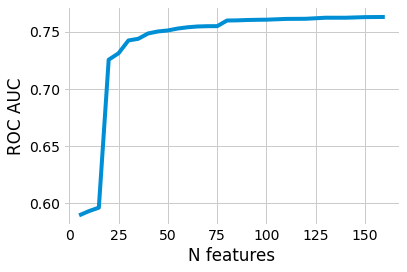

In [19]:
from sklearn.feature_selection import SelectFromModel

# imblearn pipeline does not recover the model attributes,
# The sampling steps must be performed before
sampling_pipeline = imbpipe.Pipeline([
                    ('over', oversampling),
                    ('under', undersampling)
                    ])
X_sampled, y_sampled = sampling_pipeline.fit_resample(X_pr, y)
# Create the feature selector
estimator = SGDClassifier(loss='hinge', random_state=42, average=True)
selector = SelectFromModel(estimator, threshold=-np.inf)
# Score with all features
score = cross_val_score(estimator, X_sampled, y_sampled,
                        scoring='roc_auc', cv=cv, n_jobs=-1)
print(f"ROC AUC score with {X_sampled.shape[1]} features: {score.mean():.3}")
# Select the top 160 features
sfm_scores = []
selector.max_features=160
X_sfm = selector.fit_transform(X_sampled, y_sampled)
score = cross_val_score(estimator, X_sfm, y_sampled,
                        scoring='roc_auc', cv=cv, n_jobs=-1)
sfm_scores.append(score.mean())
# Test different numbers of features from 10 to 150
for i in range(150, 100, -10):
    selector.max_features = i
    X_sfm = selector.fit_transform(X_sfm, y_sampled)
    score = cross_val_score(estimator, X_sfm, y_sampled,
                            scoring='roc_auc', cv=cv, n_jobs=-1)
    sfm_scores.append(score.mean())
for i in range(100, 0, -5):
    selector.max_features = i
    X_sfm = selector.fit_transform(X_sfm, y_sampled)
    score = cross_val_score(estimator, X_sfm, y_sampled,
                            scoring='roc_auc', cv=cv, n_jobs=-1)
    sfm_scores.append(score.mean())
# Plot the results
plt.plot(np.r_[np.arange(5, 105, 5), np.arange(110, 170, 10)],
         sfm_scores[::-1])
plt.xlabel("N features")
plt.ylabel("ROC AUC")
save_fig("roc auc vs n_features")
plt.show()

The ROC AUC decreases slowly as we keep decreasing the number of features down to 30, but then it drops quickly.
Let's continue with 80 features.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_mask):
        self.feature_mask = feature_mask
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[:, feature_mask]

In [21]:
from sklearn.feature_selection import RFE

estimator = SGDClassifier(loss='hinge', random_state=42, average=True)
selector = RFE(estimator, n_features_to_select=80, step=5)
selector.fit(X_sampled, y_sampled)
feature_mask = selector.support_

pipeline = imbpipe.Pipeline([
           ('cleaning', prep_pipeline),
           ('feature_selection', TopFeatureSelector(feature_mask=feature_mask))
           ])

X_pr = pipeline.fit_transform(X)
print(X_pr.shape)

(307511, 80)


In [22]:
compare_models(X_pr, y, models=models,
               sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,15.707855,0.071554,0.811190,0.203453,0.459174,0.281963,0.736077
SVM - Linear kernel,12.724977,0.068923,0.794602,0.194993,0.491440,0.278882,0.735217
Random Forest Classifier,47.132138,3.186504,0.906241,0.293756,0.114763,0.165022,0.722368


## Fine-Tune the hyperparameters

### Logitic Regression

In [23]:
# First Grid search
param_grid = [{'model__C': np.logspace(-3, 1, 5)}]
grid_search = GridSearchCV(models['Logistic Regression'], param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X_pr, y)
print(grid_search.best_params_)
# Second grid search
c = grid_search.best_params_['model__C']
param_grid = [{'model__C': np.linspace(c*0.5, c*5, 10)}]
grid_search = GridSearchCV(models['Logistic Regression'], param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X_pr, y)
print(grid_search.best_params_)
log_reg.C = grid_search.best_params_['model__C']

{'model__C': 0.01}
{'model__C': 0.015000000000000003}


### Linear SVM

In [24]:
# First Grid search
param_grid = [{'model__alpha': np.logspace(-6, -2, 5)}]
grid_search = GridSearchCV(models['SVM - Linear kernel'], param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X_pr, 
                y)
print(grid_search.best_params_)
# Second grid search
alpha = grid_search.best_params_['model__alpha']
step = alpha / 10
param_grid = [{'model__alpha': np.linspace(alpha*0.5, alpha*5, 10)}]
grid_search = GridSearchCV(models['SVM - Linear kernel'], param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X_pr, y)
print(grid_search.best_params_)
svm.alpha = grid_search.best_params_['model__alpha']

{'model__alpha': 0.001}
{'model__alpha': 0.002}


### Random Forest

In [25]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Bayesian search
search_spaces = {'model__max_depth': Integer(3, 15),
                 'model__max_features': Integer(3, 7),
                 'model__max_samples': Real(0.5, 1)}
bayes_search = BayesSearchCV(models['Random Forest Classifier'], search_spaces,
                             n_iter=30, scoring='recall', n_jobs=-1,
                             cv=cv, verbose=1, random_state=42)
bayes_search.fit(X_pr, y)
print(bayes_search.best_params_) 
                 
forest.max_depth = bayes_search.best_params_['model__max_depth']
forest.max_features = bayes_search.best_params_['model__max_features']
forest.max_samples = bayes_search.best_params_['model__max_samples']

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

### Stacking Classifier

Let's try a stacked model.

In [26]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import StackingClassifier

estimators = [('Logistic Regression', log_reg),
              ('svm', svm),
              ('Random Forest', forest)]
stack_clf = StackingClassifier(estimators=estimators,
                               final_estimator=RidgeClassifierCV(scoring='recall', cv=cv),
                               cv=cv,)
models['Stacking Classifier'] = imbpipe.Pipeline([
                                ('over', oversampling),  
                                ('under', undersampling),
                                ('model', stack_clf)
                                ])

### Compare Results

In [27]:
compare_models(X_pr, y, models=models,
               sort='ROC AUC')

,fit time (s),score time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,15.866242,0.074054,0.813213,0.204917,0.456073,0.282773,0.736923
SVM - Linear kernel,11.839323,0.070903,0.816569,0.206662,0.447573,0.282681,0.736374
Random Forest Classifier,30.641297,0.714117,0.894862,0.274906,0.184008,0.220345,0.724822
Stacking Classifier,132.919630,0.615886,0.882014,0.236784,0.207170,0.220853,0.705814


### Set a threshold for predicition

In [28]:
log_reg = LogisticRegression(C=0.015)
oversampling = SMOTE(random_state=42,
                     sampling_strategy=0.3)
undersampling = RandomUnderSampler(random_state=42,
                                   sampling_strategy=0.6)

final_model = imbpipe.Pipeline([
              ('over', oversampling),  
              ('under', undersampling),
              ('model', log_reg)
              ])

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_probas = cross_val_predict(final_model, X_pr, y,
                             cv=cv, n_jobs=-1, method='predict_proba')
precisions, recalls, thresholds = precision_recall_curve(y, y_probas[:, 1])

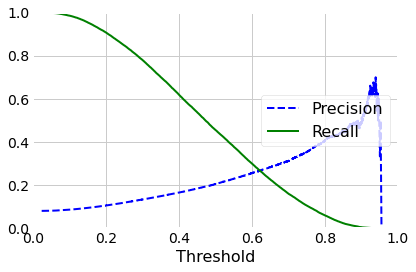

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([0, 1, 0, 1])             

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Let's take a threshold to get 90% Recall.

In [31]:
threshold_90_recall = thresholds[np.argmin(recalls>=0.90)-1]

### Final prediction

First, let's train the final model on data after sampling (over & under).

In [32]:
pipeline = Pipeline([
           ('cleaning', prep_pipeline),
           ('feature_selection', TopFeatureSelector(feature_mask=feature_mask))
           ])
X_pr = pipeline.fit_transform(X)

sampling_pipeline = imbpipe.Pipeline([
                    ('over', oversampling),
                    ('under', undersampling)
                    ])
X_sampled, y_sampled = sampling_pipeline.fit_resample(X_pr, y)

estimator = LogisticRegression(C=0.015)
estimator.fit(X_sampled, y_sampled)

LogisticRegression(C=0.015)

Then recover the feature names.

In [33]:
# Get the name of the transformed categorical features
cat_pipeline.fit(X[cat_att]) # required to get attributes, ColumnTransformer bug?
cat_mask = prep_pipeline.get_params()['cat__filter'].mask_
encoder = prep_pipeline.get_params()['cat__encoder']
cat_att_tr = encoder.get_feature_names_out(cat_att[~cat_mask])
# Get the name of the transformed ordinal features
ord_pipeline.fit(X[ord_att])
ord_mask = prep_pipeline.get_params()['ord__filter'].mask_
ord_att_tr = ord_att[~ord_mask]
# Get the name of the transformed sparse features
sparse_pipeline.fit(X[sparse_att])
sparse_mask = prep_pipeline.get_params()['sparse__filter'].mask_
sparse_att_tr = sparse_att[~sparse_mask]
# Get the name of the transformed dense features
dense_pipeline.fit(X[dense_att])
dense_mask = prep_pipeline.get_params()['dense__filter'].mask_
dense_att_tr = dense_att[~dense_mask]
domain_att = ['DAYS_EMPLOYED_PERC',
              'CREDIT_VS_INCOME',
              'INCOME_PER_PERSON',
              'ANNUITY_INCOME_PERC',
              'PAYMENT_RATE']
extra_att = np.concatenate((['DAYS_EMPLOYED_ANOM'], domain_att), axis=None)
transformer = prep_pipeline.get_params()['dense__skew_transformer']
dense_att_tr = (pd.Series(dense_att_tr)
                  .append(pd.Series(extra_att))
                  .replace(transformer.get_feature_names()))
# Concatenate all attributes
all_att = np.concatenate((cat_att_tr, ord_att_tr, sparse_att_tr, dense_att_tr),
                         axis=None)
# Use the rfe mask
final_att = all_att[feature_mask]

Eventually, create a function to get final predictions based on the threshold previously chosen.

In [34]:
def predict_90_recall(X):
    return estimator.predict_proba(X)[:, 1] >= threshold_90_recall

We should save the pipeline to prepare data as well as the final predictor. For that, let's use the `joblib` library.

In [35]:
import joblib

joblib.dump(pipeline, 'prep_pipeline.pkl')
joblib.dump(predict_90_recall, 'predictor.pkl')

['predictor.pkl']

## Analyse feature importance with SHAP

To better understand our model we will use the *SHAP* (SHapley Additive exPlanations) method, which is based on Shapley values.  
SHAP is better than just analysing feature importance for at least three reasons:
1. Global interpretability &ndash; it is able to show if the relationship for each variable with the target is positive or negative,
2. Local interpretability &ndash; the results are shown for each individual case and not across the entire population.
3. It can be calculated for any models, while other methods generally use linear or logistic regression as the surrogate model.

In [36]:
import shap

#background dataset set to the mean values
means =  np.mean(pipeline.transform(X), axis=0).reshape(1, -1)
explainer = shap.KernelExplainer(predict_90_recall, means)

Let's see the results for the firt 1000 clients.

  0%|          | 0/1000 [00:00<?, ?it/s]

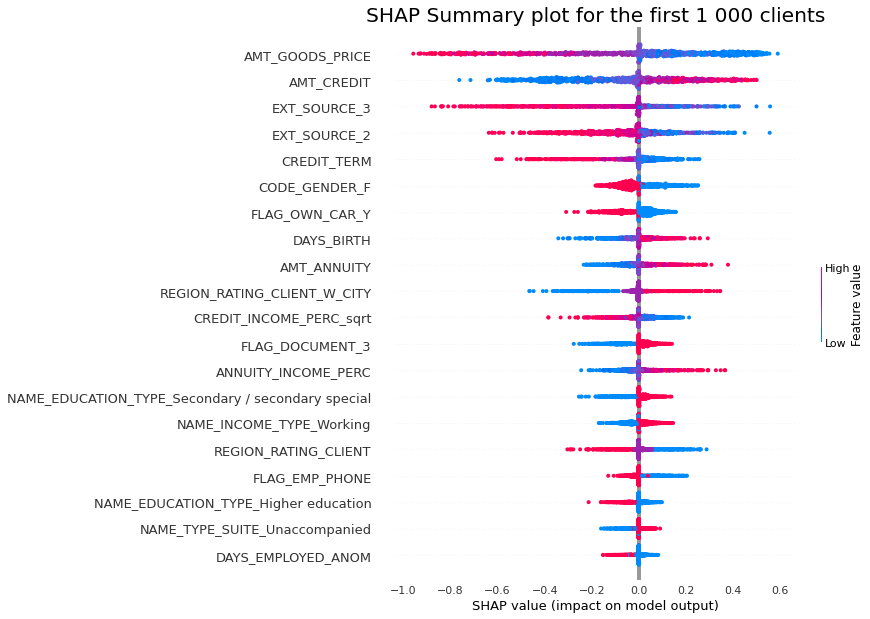

In [37]:
# Get a sample with the first 1 000 clients
sample = pipeline.transform(X.iloc[:1_000])
sample_values = explainer.shap_values(sample)

shap.summary_plot(sample_values, sample, feature_names=final_att,
                        max_display=20, show=False)
plt.grid(False)
plt.title('SHAP Summary plot for the first 1 000 clients')
save_fig('SHAP Summary plot', tight_layout=False)
plt.show()

To be noted that four features among the six created are in the top 20: 
- Credit Term,
- Annuity income Percentage,
- Credit income Percentage, and
- Days Employed Anomalies

Let's go deeper into the analysis with the *force plot*.

In [38]:
# Initialize the Jupyter notebook with initjs()
shap.initjs()

shap.force_plot(explainer.expected_value, sample_values[1],
                sample[1:2], feature_names=final_att)


## Appendix, XGBoost fine-tuning

In [39]:
from sklearn.model_selection import train_test_split

xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')

models['XGBoost Classifier'] = imbpipe.Pipeline([
                                   ('over', oversampling),  
                                   ('under', undersampling),
                                   ('model', xgb)
                                   ])

search_spaces = [{'model__max_depth': Integer(6, 20),
                  'model__learning_rate': Real(0.01, 0.2),
                  'model__colsample_bytree':(0.3, 1.0)
                 }]
bayes_search = BayesSearchCV(models['XGBoost Classifier'], search_spaces,
                             n_iter=30, scoring='recall', n_jobs=-1,
                             cv=cv, verbose=2, random_state=42)
bayes_search.fit(X_pr, y)
print(bayes_search.best_params_)
print(bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [40]:
# Split the data set into a train and test set
# to use early stopping
X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(X_pr, y, random_state=42)
# resampling the training set with SMOTE and undersampling
X_gb_train, y_gb_train = sampling_pipeline.fit_resample(X_gb_train, y_gb_train)
# Recover the best hyper-parameters for XGBoost
xgb.max_depth = bayes_search.best_params_['model__max_depth']
xgb.learning_rate = bayes_search.best_params_['model__learning_rate']
xgb.colsample_bytree = bayes_search.best_params_['model__colsample_bytree']
# Get the best n_estimators with early stopping
xgb.fit(X_gb_train, y_gb_train,
        eval_set=[(X_gb_test, y_gb_test)],
        eval_metric='logloss',
        early_stopping_rounds=3,
        verbose=False)
xgb.n_estimators = xgb.best_iteration + 1
print("The best iteration is {}".format(xgb.n_estimators))

The best iteration is 100


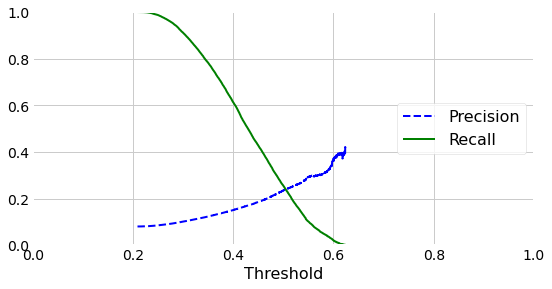

In [41]:
y_probas = cross_val_predict(models['XGBoost Classifier'], X_pr, y,
                             cv=cv, n_jobs=-1, method='predict_proba')
precisions, recalls, thresholds = precision_recall_curve(y, y_probas[:, 1])

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()